In [79]:
import numpy as np
import itertools
import scipy
from scipy.signal import welch
from mne.time_frequency import psd_array_multitaper
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

# ---Lorenz system simulations---
def LorenzEqs(t,X,sigma,rho,beta):
    x = X[0]
    y = X[1]
    z = X[2]
    x_dot = sigma*(y-x)
    y_dot = x*(rho-z)-y
    z_dot = x*y-beta*z
    return [x_dot,y_dot,z_dot]

def simulateLorenzSystem(X0,Deltat_sim,gridDensity,sigma,rho,beta):
    # numerical integration
    t_span = [0,Deltat_sim]
    t_eval = np.linspace(0,Deltat_sim,gridDensity*Deltat_sim+1)
    soln = scipy.integrate.solve_ivp(LorenzEqs,t_span,X0,args=[sigma,rho,beta],method="RK45",t_eval=t_eval)
    t = soln.t
    [x,y,z] = soln.y
    # exact derivatives from simulation
    x_dot = []
    y_dot = []
    z_dot = []
    for i in range(0,len(t)):
        X = [x[i],y[i],z[i]]
        [dxdt,dydt,dzdt] = LorenzEqs(t,X,sigma,rho,beta)
        x_dot.append(dxdt)
        y_dot.append(dydt)
        z_dot.append(dzdt)
    # log data
    t_out = np.array(t).reshape(len(t),1)
    x = np.array(x).reshape(len(t),1)
    y = np.array(y).reshape(len(t),1)
    z = np.array(z).reshape(len(t),1)
    X_out = np.hstack([x,y,z])
    x_dot = np.array(x_dot).reshape(len(t),1)
    y_dot = np.array(y_dot).reshape(len(t),1)
    z_dot = np.array(z_dot).reshape(len(t),1)
    X_dot_out = np.hstack([x_dot,y_dot,z_dot])
    return [t_out,X_out,X_dot_out]

# ---library---
def calcTheta_poly_3D(arr_t,arr_x,arr_y,arr_z,order=5):
    n = len(arr_t)

    # generate all (i,j,k) such that i+j+k <= order
    exponents = []
    for total in range(order+1):
        for i,j,k in itertools.product(range(total+1),repeat=3):
            if i+j+k == total:
                exponents.append((i,j,k))   # exponents includes constants (0,0,0)，first order terms (1,0,0) and all other combinations
    
    # compute library
    Theta = np.zeros((n,len(exponents)))
    for ind,(i,j,k) in enumerate(exponents):
        Theta[:,ind] = (arr_x**i)*(arr_y**j)*(arr_z**k)
    
    return Theta,exponents

def indexOf(exps,target):
    return exps.index(target)

def trueCoeffMatrix_Lorenz(exps,sigma,rho,beta):
    n = len(exps)
    w_true = np.zeros((n,3))

    # xD = -sigma*x+sigma*y
    w_true[indexOf(exps,(1,0,0)),0] = -sigma   # x
    w_true[indexOf(exps,(0,1,0)),0] = sigma    # y

    # yD = rho*x-y-x*z
    w_true[indexOf(exps,(1,0,0)),1] = rho      # x
    w_true[indexOf(exps,(0,1,0)),1] = -1       # y
    w_true[indexOf(exps,(1,0,1)),1] = -1       # x*z

    # zD = -beta*z+x*y
    w_true[indexOf(exps,(0,0,1)),2] = -beta    # z
    w_true[indexOf(exps,(1,1,0)),2] = 1        # x*y

    return w_true

# ---sparse regression---
def sparseRegression_prescribedLambda(A,b,params_regression):
    method = params_regression["method"]
    if method == "least-squares":
        N_loops = params_regression["N_loops"]
        lambda_sparse = params_regression["lambda_sparse"]
        x = np.linalg.pinv(A)@b
        x = x.flatten()
        b = b.flatten()
        for i in range(1,N_loops+1):
            smallInds = abs(x)<lambda_sparse
            x[smallInds] = 0
            bigInds = ~smallInds 
            x[bigInds] = np.linalg.pinv(A[:,bigInds])@b
    elif method == "ridge":
        N_loops = params_regression["N_loops"]
        lambda_sparse = params_regression["lambda_sparse"]
        lambda_ridge = params_regression["lambda_ridge"]
        x = np.linalg.solve(A.T@A+lambda_ridge*np.eye(A.shape[1]),A.T@b)
        x = x.flatten()
        b = b.flatten()
        for i in range(1,N_loops+1):
            smallInds = abs(x)<lambda_sparse
            x[smallInds] = 0
            bigInds = ~smallInds 
            x[bigInds] = np.linalg.solve(A[:,bigInds].T@A[:,bigInds]+lambda_ridge*np.eye(A[:,bigInds].shape[1]),A[:,bigInds].T@b)
    elif method == "lasso":
        lambda_lasso = params_regression["lambda_lasso"]
        lasso = Lasso(alpha=lambda_lasso)
        lasso.fit(A,b)
        x = lasso.coef_
    x = x.reshape(-1,1)
    return x

# ---Fourier weak SINDy---
def constructLS_FFT_PSD(t_out,x_i,array_n,Theta):
    Deltat = t_out[1]-t_out[0]
    N = len(t_out.flatten())
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])

    # compute Fourier coefficients for state variable
    f_hat_x_i = np.fft.fft(x_i.flatten())   # FFT
    f_hat_x_i = f_hat_x_i/N   # Fourier coefficients
    a_n_x_i = 2*f_hat_x_i.real
    b_n_x_i = -2*f_hat_x_i.imag

    # compute Fourier coefficients for dictionary terms
    a_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    b_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    for i in range(0,Theta.shape[1]):
        f_hat = np.fft.fft(Theta[:,i].flatten())    # FFT
        f_hat = f_hat/N   # Fourier coefficients
        a_n_Theta[:,i] = 2*f_hat.real
        b_n_Theta[:,i] = -2*f_hat.imag

    # compute A and b
    A = b_n_Theta[array_n,:]
    N_n = len(array_n)
    b = np.zeros((N_n,1))
    for i in range(0,N_n):
        n = array_n[i]
        b[i] = -n*omega0*a_n_x_i[n]

    return A,b

def constructLS_Fourier_FFT(t_out,x_i,array_n,Theta):
    Deltat = t_out[1]-t_out[0]
    N = len(t_out.flatten())
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])

    # compute Fourier coefficients for state variable
    f_hat_x_i = np.fft.fft(x_i.flatten())   # FFT
    f_hat_x_i = f_hat_x_i/N   # Fourier coefficients
    a_n_x_i = 2*f_hat_x_i.real
    b_n_x_i = -2*f_hat_x_i.imag

    # compute Fourier coefficients for dictionary terms
    a_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    b_n_Theta = np.zeros((len(t_out),Theta.shape[1]))
    for i in range(0,Theta.shape[1]):
        f_hat = np.fft.fft(Theta[:,i].flatten())    # FFT
        f_hat = f_hat/N   # Fourier coefficients
        a_n_Theta[:,i] = 2*f_hat.real
        b_n_Theta[:,i] = -2*f_hat.imag

    # compute A and b
    N_n = len(array_n)

    A = b_n_Theta[1:N_n+1,:]
    b = np.zeros((N_n,1))
    for i in range(0,N_n):
        n = i+1
        b[i] = -n*omega0*a_n_x_i[n]

    return A,b

def getFreqInds_PSD_Welch(t,x_i,N_freq):
    # get top frequencies from PSD
    f,phi = welch(x_i,fs=1/(t[1]-t[0]),nperseg=len(t)//5)
    topFreqs_PSD = f[np.argsort(-phi)[:N_freq]]

    # FFT frequencies
    FFT_freqs = np.fft.fftfreq(len(x_i),t[1]-t[0])
    FFT_freqs = FFT_freqs[:len(t)//2]

    # match PSD frequencies to nearest FFT frequencies 
    freqInds_FFT = np.zeros(len(topFreqs_PSD),dtype=int)
    for ind,f_PSD in enumerate(topFreqs_PSD):
        i_FFT = np.argmin(np.abs(FFT_freqs-f_PSD))
        freqInds_FFT[ind] = i_FFT
    
    return freqInds_FFT

def getFreqInds_PSD_multiTaper(t,x_i,N_freq):
    # get top frequencies from PSD
    phi,f = psd_array_multitaper(x_i,1/(t[1]-t[0]),remove_dc=True,fmin=0,fmax=1000,bandwidth=15,normalization="full",verbose=False)
    topFreqs_PSD = f[np.argsort(-phi)[:N_freq]]

    # FFT frequencies
    FFT_freqs = np.fft.fftfreq(len(x_i),t[1]-t[0])
    FFT_freqs = FFT_freqs[:len(t)//2]

    # match PSD frequencies to nearest FFT frequencies 
    freqInds_FFT = np.zeros(len(topFreqs_PSD),dtype=int)
    for ind,f_PSD in enumerate(topFreqs_PSD):
        i_FFT = np.argmin(np.abs(FFT_freqs-f_PSD))
        freqInds_FFT[ind] = i_FFT
    
    return freqInds_FFT

def getFreqInds_FFT(t,x_i,N_freq):
    # get top frequencies from FFT magnitudes
    FFT_vals = np.fft.fft(x_i)
    FFT_mags = np.abs(FFT_vals)[:len(t)//2]
    freqInds_FFT = np.argsort(-FFT_mags)[:N_freq]

    return freqInds_FFT

def WSINDy_Fourier_FFT_Lorenz(t_out,X_out,N_freq,params_regression,polyOrder=2):
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])
    arr_x = X_out[:,0]
    arr_y = X_out[:,1]
    arr_z = X_out[:,2]
    # set n-values
    arr_n_x = np.linspace(1,N_freq,N_freq)
    arr_n_y = np.linspace(1,N_freq,N_freq)
    arr_n_z = np.linspace(1,N_freq,N_freq)
    # library
    Theta,_ = calcTheta_poly_3D(t_out,arr_x,arr_y,arr_z,order=polyOrder)
    # A and b
    A1,b1 = constructLS_Fourier_FFT(t_out,arr_x,arr_n_x,Theta)
    A2,b2 = constructLS_Fourier_FFT(t_out,arr_y,arr_n_y,Theta)
    A3,b3 = constructLS_Fourier_FFT(t_out,arr_z,arr_n_z,Theta)
    # sparse regressions
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A1,b1,params_regression)
        w2 = sparseRegression_autoLambda(A2,b2,params_regression)
        w3 = sparseRegression_autoLambda(A3,b3,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A1,b1,params_regression)
        w2 = sparseRegression_prescribedLambda(A2,b2,params_regression)
        w3 = sparseRegression_prescribedLambda(A3,b3,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

def WSINDy_FFT_PSD_Lorenz(t_out,X_out,N_freq,params_regression,polyOrder=2):
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])
    arr_x = X_out[:,0]
    arr_y = X_out[:,1]
    arr_z = X_out[:,2]
    # set n-values
    arr_n_x = getFreqInds_PSD_multiTaper(t_out,arr_x,N_freq)
    arr_n_y = getFreqInds_PSD_multiTaper(t_out,arr_y,N_freq)
    arr_n_z = getFreqInds_PSD_multiTaper(t_out,arr_z,N_freq)
    # library
    Theta,_ = calcTheta_poly_3D(t_out,arr_x,arr_y,arr_z,order=polyOrder)
    # A and b
    A1,b1 = constructLS_FFT_PSD(t_out,arr_x,arr_n_x,Theta)
    A2,b2 = constructLS_FFT_PSD(t_out,arr_y,arr_n_y,Theta)
    A3,b3 = constructLS_FFT_PSD(t_out,arr_z,arr_n_z,Theta)
    # sparse regressions
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A1,b1,params_regression)
        w2 = sparseRegression_autoLambda(A2,b2,params_regression)
        w3 = sparseRegression_autoLambda(A3,b3,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A1,b1,params_regression)
        w2 = sparseRegression_prescribedLambda(A2,b2,params_regression)
        w3 = sparseRegression_prescribedLambda(A3,b3,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

def WSINDy_FFT_FFT_Lorenz(t_out,X_out,X_clean,N_freq,params_regression,polyOrder=2):
    omega0 = 2*np.pi/(t_out[-1]-t_out[0])
    arr_x = X_out[:,0]
    arr_y = X_out[:,1]
    arr_z = X_out[:,2]
    # set n-values
    arr_n_x = getFreqInds_FFT(t_out,X_clean[:,0],N_freq)
    arr_n_y = getFreqInds_FFT(t_out,X_clean[:,1],N_freq)
    arr_n_z = getFreqInds_FFT(t_out,X_clean[:,2],N_freq)
    # library
    Theta,_ = calcTheta_poly_3D(t_out,arr_x,arr_y,arr_z,order=polyOrder)
    # A and b
    A1,b1 = constructLS_FFT_PSD(t_out,arr_x,arr_n_x,Theta)
    A2,b2 = constructLS_FFT_PSD(t_out,arr_y,arr_n_y,Theta)
    A3,b3 = constructLS_FFT_PSD(t_out,arr_z,arr_n_z,Theta)
    # sparse regressions
    if params_regression["lambda_sparse"] == "auto":
        w1 = sparseRegression_autoLambda(A1,b1,params_regression)
        w2 = sparseRegression_autoLambda(A2,b2,params_regression)
        w3 = sparseRegression_autoLambda(A3,b3,params_regression)
    else:
        w1 = sparseRegression_prescribedLambda(A1,b1,params_regression)
        w2 = sparseRegression_prescribedLambda(A2,b2,params_regression)
        w3 = sparseRegression_prescribedLambda(A3,b3,params_regression)

    w = np.hstack([w1,w2,w3])
    return w

# ---error evaluations---
def errorEval(w_true,w_ident):
    # relative error norm
    e = w_true-w_ident
    errorNorm = np.linalg.norm(e,"fro")
    errorNorm_rel = errorNorm/np.linalg.norm(w_true,"fro")
    # spurious terms and terms failed to be identified
    N_spurious = np.sum((w_true==0) & (w_ident!=0))
    N_failed = np.sum((w_true!=0) & (w_ident==0))
    # TPR
    N_correct = np.sum((w_true==0) & (w_ident==0))
    TPR = N_correct/(N_correct+N_spurious+N_failed)   
    return errorNorm_rel,TPR

def batchErrorEval(w_true,arr_w):
    n_noiseLevels = arr_w.shape[2]
    N_noise = arr_w.shape[3]

    error_all = np.zeros((n_noiseLevels,N_noise))
    TPR_all = np.zeros((n_noiseLevels,N_noise))

    # loop over noise levels and trials
    for i in range(n_noiseLevels):
        for j in range(N_noise):
            w_ident = arr_w[:,:,i,j]
            eNorm,TPR = errorEval(w_true,w_ident)
            error_all[i,j] = eNorm
            TPR_all[i,j] = TPR

    # compute statistics
    error_mean = np.median(error_all,axis=1)
    error_q1 = np.percentile(error_all,25,axis=1)
    error_q3 = np.percentile(error_all,75,axis=1)
    TPR_mean = np.median(TPR_all,axis=1)
    TPR_q1 = np.percentile(TPR_all,25,axis=1)
    TPR_q3 = np.percentile(TPR_all,75,axis=1)

    results = {
        "error_mean": error_mean,
        "error_q1": error_q1,
        "error_q3": error_q3,
        "TPR_mean": TPR_mean,
        "TPR_q1": TPR_q1,
        "TPR_q3": TPR_q3
    }

    return results

# ---plotting function---
def plotWithQuartiles(x,mean,q1,q3,label,color):
    plt.plot(x,mean,label=label,color=color)
    plt.fill_between(x,q1,q3,color=color,alpha=0.5)

In [80]:
# ---simulate Lorenz system and add noise---
# system parameters
sigma = 10
rho = 28
beta = 8/3

# simulate
X0 = np.array([20,12,-30])
t_sim = 10
gridDensity = 1000
t_span = [0,t_sim]
[t_out,X_clean,X_dot_out] = simulateLorenzSystem(X0,t_sim,gridDensity,sigma,rho,beta)

# add noise
MD = t_sim*gridDensity*3
arr_sig_NR = np.hstack((np.logspace(-6,-2,5),np.linspace(0.05,0.4,8)))   # array of noise ratios
N_noise = 10   # number of noises to try at each noise level
arr_X_noisy = np.zeros((X_clean.shape[0],X_clean.shape[1],len(arr_sig_NR),N_noise)) # allocte a 4-way array for storing noisy trajectory data

rng = np.random.default_rng(seed=0)
for i in range(0,len(arr_sig_NR)):
    sig_NR = arr_sig_NR[i]
    sig = sig_NR*np.linalg.norm(X_clean,"fro")/np.sqrt(MD)
    for j in range(0,N_noise):
        X_noisy = X_clean+rng.normal(0,sig,size=X_clean.shape)
        arr_X_noisy[:,:,i,j] = X_noisy

# true coefficient matrix (up to fifth-order polynomials)
Theta,exps = calcTheta_poly_3D(t_out[1:-1],X_clean[1:-1,0],X_clean[1:-1,1],X_clean[1:-1,2],order=2)
w_true = trueCoeffMatrix_Lorenz(exps,sigma,rho,beta)

In [81]:
# ---Fourier weak SINDy (FFT frequency selections)---
# sparse regression settings
params_regression = dict()
params_regression["method"] = "ridge"
params_regression["lambda_sparse"] = 0.5
params_regression["lambda_ridge"] = 0.001
params_regression["N_loops"] = 100

# evaluate error at different noise levels
N_freq = 100
arr_w_FFTWSINDy_FFT = np.zeros((w_true.shape[0],w_true.shape[1],len(arr_sig_NR),N_noise))

for i in range(0,len(arr_sig_NR)):
    for j in range(0,N_noise):
        X_noisy = arr_X_noisy[:,:,i,j]
        w_ident = WSINDy_FFT_FFT_Lorenz(t_out,X_noisy,X_clean,N_freq,params_regression,polyOrder=2)
        arr_w_FFTWSINDy_FFT[:,:,i,j] = w_ident
        print(f"Progress 1/3: {i*N_noise+(j+1)}/{len(arr_sig_NR)*N_noise}")

Progress 1/3: 1/130
Progress 1/3: 2/130
Progress 1/3: 3/130
Progress 1/3: 4/130
Progress 1/3: 5/130
Progress 1/3: 6/130
Progress 1/3: 7/130
Progress 1/3: 8/130
Progress 1/3: 9/130
Progress 1/3: 10/130
Progress 1/3: 11/130
Progress 1/3: 12/130
Progress 1/3: 13/130
Progress 1/3: 14/130
Progress 1/3: 15/130
Progress 1/3: 16/130
Progress 1/3: 17/130
Progress 1/3: 18/130
Progress 1/3: 19/130
Progress 1/3: 20/130
Progress 1/3: 21/130
Progress 1/3: 22/130
Progress 1/3: 23/130
Progress 1/3: 24/130
Progress 1/3: 25/130
Progress 1/3: 26/130
Progress 1/3: 27/130
Progress 1/3: 28/130
Progress 1/3: 29/130
Progress 1/3: 30/130
Progress 1/3: 31/130
Progress 1/3: 32/130
Progress 1/3: 33/130
Progress 1/3: 34/130
Progress 1/3: 35/130
Progress 1/3: 36/130
Progress 1/3: 37/130
Progress 1/3: 38/130
Progress 1/3: 39/130
Progress 1/3: 40/130
Progress 1/3: 41/130
Progress 1/3: 42/130
Progress 1/3: 43/130
Progress 1/3: 44/130
Progress 1/3: 45/130
Progress 1/3: 46/130
Progress 1/3: 47/130
Progress 1/3: 48/130
P

In [82]:
# ---Fourier weak SINDy (PSD frequency selections)---
# sparse regression settings
params_regression = dict()
params_regression["method"] = "ridge"
params_regression["lambda_sparse"] = 0.5
params_regression["lambda_ridge"] = 0.001
params_regression["N_loops"] = 100

# evaluate error at different noise levels
N_freq = 100
arr_w_FFTWSINDy_PSD = np.zeros((w_true.shape[0],w_true.shape[1],len(arr_sig_NR),N_noise))

for i in range(0,len(arr_sig_NR)):
    for j in range(0,N_noise):
        X_noisy = arr_X_noisy[:,:,i,j]
        w_ident = WSINDy_FFT_PSD_Lorenz(t_out,X_noisy,N_freq,params_regression,polyOrder=2)
        arr_w_FFTWSINDy_PSD[:,:,i,j] = w_ident
        print(f"Progress 2/3: {i*N_noise+(j+1)}/{len(arr_sig_NR)*N_noise}")

Progress 2/3: 1/130
Progress 2/3: 2/130
Progress 2/3: 3/130
Progress 2/3: 4/130
Progress 2/3: 5/130
Progress 2/3: 6/130
Progress 2/3: 7/130
Progress 2/3: 8/130
Progress 2/3: 9/130
Progress 2/3: 10/130
Progress 2/3: 11/130
Progress 2/3: 12/130
Progress 2/3: 13/130
Progress 2/3: 14/130
Progress 2/3: 15/130
Progress 2/3: 16/130
Progress 2/3: 17/130
Progress 2/3: 18/130
Progress 2/3: 19/130
Progress 2/3: 20/130
Progress 2/3: 21/130
Progress 2/3: 22/130
Progress 2/3: 23/130
Progress 2/3: 24/130
Progress 2/3: 25/130
Progress 2/3: 26/130
Progress 2/3: 27/130
Progress 2/3: 28/130
Progress 2/3: 29/130
Progress 2/3: 30/130
Progress 2/3: 31/130
Progress 2/3: 32/130
Progress 2/3: 33/130
Progress 2/3: 34/130
Progress 2/3: 35/130
Progress 2/3: 36/130
Progress 2/3: 37/130
Progress 2/3: 38/130
Progress 2/3: 39/130
Progress 2/3: 40/130
Progress 2/3: 41/130
Progress 2/3: 42/130
Progress 2/3: 43/130
Progress 2/3: 44/130
Progress 2/3: 45/130
Progress 2/3: 46/130
Progress 2/3: 47/130
Progress 2/3: 48/130
P

In [83]:
# ---Fourier weak SINDy (brute-force sweep)---
# sparse regression settings
params_regression = dict()
params_regression["method"] = "ridge"
params_regression["lambda_sparse"] = 0.5
params_regression["lambda_ridge"] = 0.001
params_regression["N_loops"] = 100

# evaluate error at different noise levels
N_freq = 500
arr_w_FFTWSINDy_sweep = np.zeros((w_true.shape[0],w_true.shape[1],len(arr_sig_NR),N_noise))

for i in range(0,len(arr_sig_NR)):
    for j in range(0,N_noise):
        X_noisy = arr_X_noisy[:,:,i,j]
        w_ident = WSINDy_Fourier_FFT_Lorenz(t_out,X_noisy,N_freq,params_regression,polyOrder=2)
        arr_w_FFTWSINDy_sweep[:,:,i,j] = w_ident
        print(f"Progress 3/3: {i*N_noise+(j+1)}/{len(arr_sig_NR)*N_noise}")

Progress 3/3: 1/130
Progress 3/3: 2/130
Progress 3/3: 3/130
Progress 3/3: 4/130
Progress 3/3: 5/130
Progress 3/3: 6/130
Progress 3/3: 7/130
Progress 3/3: 8/130
Progress 3/3: 9/130
Progress 3/3: 10/130
Progress 3/3: 11/130
Progress 3/3: 12/130
Progress 3/3: 13/130
Progress 3/3: 14/130
Progress 3/3: 15/130
Progress 3/3: 16/130
Progress 3/3: 17/130
Progress 3/3: 18/130
Progress 3/3: 19/130
Progress 3/3: 20/130
Progress 3/3: 21/130
Progress 3/3: 22/130
Progress 3/3: 23/130
Progress 3/3: 24/130
Progress 3/3: 25/130
Progress 3/3: 26/130
Progress 3/3: 27/130
Progress 3/3: 28/130
Progress 3/3: 29/130
Progress 3/3: 30/130
Progress 3/3: 31/130
Progress 3/3: 32/130
Progress 3/3: 33/130
Progress 3/3: 34/130
Progress 3/3: 35/130
Progress 3/3: 36/130
Progress 3/3: 37/130
Progress 3/3: 38/130
Progress 3/3: 39/130
Progress 3/3: 40/130
Progress 3/3: 41/130
Progress 3/3: 42/130
Progress 3/3: 43/130
Progress 3/3: 44/130
Progress 3/3: 45/130
Progress 3/3: 46/130
Progress 3/3: 47/130
Progress 3/3: 48/130
P

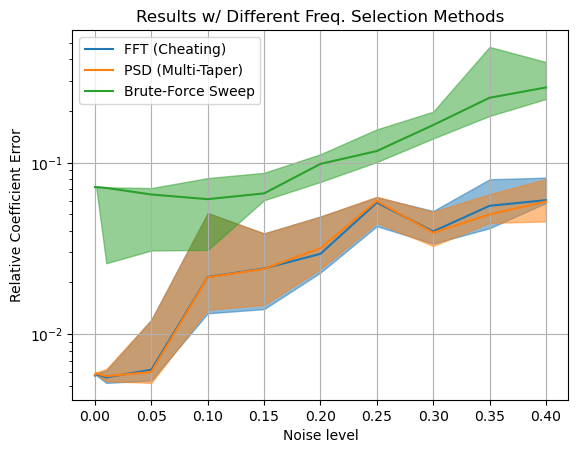

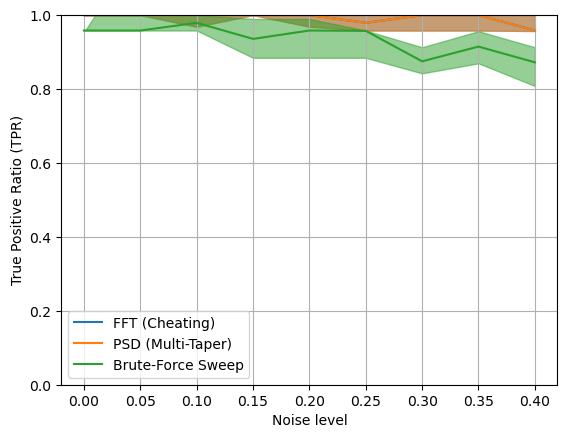

In [84]:
# ---statistics---
res_FFT = batchErrorEval(w_true,arr_w_FFTWSINDy_FFT)
res_PSD = batchErrorEval(w_true,arr_w_FFTWSINDy_PSD)
res_sweep = batchErrorEval(w_true,arr_w_FFTWSINDy_sweep)

# ---Noise level vs. coefficient error---
plt.figure()
plotWithQuartiles(arr_sig_NR,res_FFT["error_mean"],res_FFT["error_q1"],res_FFT["error_q3"],"FFT (Cheating)","C0")
plotWithQuartiles(arr_sig_NR,res_PSD["error_mean"],res_PSD["error_q1"],res_PSD["error_q3"],"PSD (Multi-Taper)","C1")
plotWithQuartiles(arr_sig_NR,res_sweep["error_mean"],res_sweep["error_q1"],res_sweep["error_q3"],"Brute-Force Sweep","C2")
# plt.xscale("log")
plt.yscale("log")
plt.xlabel("Noise level")
plt.ylabel("Relative Coefficient Error")
plt.title("Results w/ Different Freq. Selection Methods")
plt.legend()
plt.grid(True)

# ---Noise level vs. TPR---
plt.figure()
plt.ylim(0,1.0)
plotWithQuartiles(arr_sig_NR,res_FFT["TPR_mean"],res_FFT["TPR_q1"],res_FFT["TPR_q3"],"FFT (Cheating)","C0")
plotWithQuartiles(arr_sig_NR, res_PSD["TPR_mean"],res_PSD["TPR_q1"],res_PSD["TPR_q3"],"PSD (Multi-Taper)","C1")
plotWithQuartiles(arr_sig_NR, res_sweep["TPR_mean"],res_sweep["TPR_q1"],res_sweep["TPR_q3"],"Brute-Force Sweep","C2")
# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Noise level")
plt.ylabel("True Positive Ratio (TPR)")
plt.legend()
plt.grid(True)

plt.show()

In [85]:
f_s = 1/(t_out[1]-t_out[0])
